<a href="https://colab.research.google.com/github/zSoftwareRepository/MDS-561-46-22SU/blob/main/Autoencoder_cv_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
seed = 23

import numpy as np
np.random.seed(seed)

from tensorflow.keras.utils import set_random_seed 
set_random_seed(seed)

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import load_model, Model

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

import math

In [110]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = tf.keras.Sequential([
                       tf.keras.layers.Dense(24, activation="elu",input_shape=(features,)),
                       tf.keras.layers.Dropout(0.2),
                       tf.keras.layers.Dense(20, activation="elu"),
                       tf.keras.layers.Dropout(0.2),
                       tf.keras.layers.Dense(16, activation="elu"),
                       tf.keras.layers.Dropout(0.2),
                       tf.keras.layers.Dense(8, activation="elu"),
                       ])
        self.decoder = tf.keras.Sequential([
                       tf.keras.layers.Dense(16, activation="elu"),
                       tf.keras.layers.Dense(20, activation="elu"),
                       tf.keras.layers.Dense(24, activation="elu"),
                       tf.keras.layers.Dense(features, activation="sigmoid")
                       ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def get_config(self):
        base_config = super().get_config()
        return{**base_config, "output_dim" : output_dim, "activation": activation}

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [111]:
data = pd.read_csv('drive/MyDrive/data/creditcard.csv')

In [112]:
Class = pd.DataFrame(data['Class'],columns=['Class'])

In [113]:
data.drop(['Time', 'Class'], axis=1,inplace=True)

In [114]:
data0  = data[Class['Class']==0].reset_index(drop=True)
class0 = Class[Class['Class']==0].reset_index(drop=True)

data1  = data[Class['Class']==1].reset_index(drop=True)
class1 = Class[Class['Class']==1].reset_index(drop=True)

In [115]:
folds = pd.DataFrame(np.zeros(data0.shape[0]),columns=['fold'])
folds.index = data0.index

n_folds = 10

kf = KFold(n_splits=n_folds)

for n, (train_index, val_index) in enumerate(kf.split(data0)):
    folds.loc[val_index, 'fold'] = int(n)

folds.loc[:,'fold'] = folds.loc[:,'fold'].astype(int)

In [116]:
val_idx = folds[folds['fold'] == 0].index 
holdout = data0.iloc[val_idx].reset_index(drop=True).copy()
Class_holdout = class0.iloc[val_idx].reset_index(drop=True).copy()

In [117]:
trn_idx = folds[folds['fold'] != 0].index
data0 = data0.iloc[trn_idx].reset_index(drop=True).copy()

In [118]:
folds = pd.DataFrame(np.zeros(data0.shape[0]),columns=['fold'])
folds.index = data0.index

n_folds = 10

kf = KFold(n_splits=n_folds)

for n, (train_index, val_index) in enumerate(kf.split(data0)):
    folds.loc[val_index, 'fold'] = int(n)

folds.loc[:,'fold'] = folds.loc[:,'fold'].astype(int)

In [119]:
learning_rate = 1e-3
i_count = 0
models = []
fscalers = []

for fold_num in range(n_folds):
     print(f'Fold {fold_num}')
        
     trn_idx = folds[folds['fold'] != fold_num].index
     val_idx = folds[folds['fold'] == fold_num].index    

     X_train = data0.iloc[trn_idx].reset_index(drop=True).values.copy()
     X_test  = data0.iloc[val_idx].reset_index(drop=True).values.copy()
        
     tf.keras.backend.clear_session()
     features = X_train.shape[1]

     model = AutoEncoder()

     scaler = MinMaxScaler()
     scaler.fit(X_train)
     fscalers.append(scaler)
     X_train = scaler.transform(X_train)
     X_test  = scaler.transform(X_test)

     cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 2, verbose = 0, min_delta = 0.001, mode = 'min')
     es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")

     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),loss="mae")
     history = model.fit(X_train, X_train, epochs=100, batch_size=128,
                         validation_data=(X_test, X_test),
                         shuffle=True,
                         callbacks=[cb_lr,es],
                         verbose=2)
      
     models.append(model)
     i_count += 1

Fold 0
Epoch 1/100
1800/1800 - 7s - loss: 0.0303 - val_loss: 0.0267 - lr: 0.0010 - 7s/epoch - 4ms/step
Epoch 2/100
1800/1800 - 6s - loss: 0.0249 - val_loss: 0.0219 - lr: 0.0010 - 6s/epoch - 3ms/step
Epoch 3/100
1800/1800 - 5s - loss: 0.0218 - val_loss: 0.0178 - lr: 0.0010 - 5s/epoch - 3ms/step
Epoch 4/100
1800/1800 - 5s - loss: 0.0201 - val_loss: 0.0165 - lr: 0.0010 - 5s/epoch - 3ms/step
Epoch 5/100
1800/1800 - 5s - loss: 0.0196 - val_loss: 0.0158 - lr: 0.0010 - 5s/epoch - 3ms/step
Epoch 6/100
1800/1800 - 5s - loss: 0.0194 - val_loss: 0.0160 - lr: 0.0010 - 5s/epoch - 3ms/step
Epoch 7/100
1800/1800 - 5s - loss: 0.0192 - val_loss: 0.0157 - lr: 4.0000e-04 - 5s/epoch - 3ms/step
Epoch 8/100
1800/1800 - 6s - loss: 0.0192 - val_loss: 0.0156 - lr: 4.0000e-04 - 6s/epoch - 3ms/step
Epoch 9/100
1800/1800 - 5s - loss: 0.0191 - val_loss: 0.0156 - lr: 1.6000e-04 - 5s/epoch - 3ms/step
Epoch 10/100
1800/1800 - 6s - loss: 0.0191 - val_loss: 0.0156 - lr: 1.6000e-04 - 6s/epoch - 3ms/step
Epoch 11/100
180

In [125]:
decoder_out = np.zeros( (holdout.shape) , dtype=np.float64)

for fold in range(n_folds):
  #Test data
  scaler = fscalers[fold]
  X_test  = scaler.transform(holdout)

  encoder_out = model.encoder(X_test).numpy() 
  decoder_out += model.decoder(encoder_out).numpy()

decoder_out /= n_folds

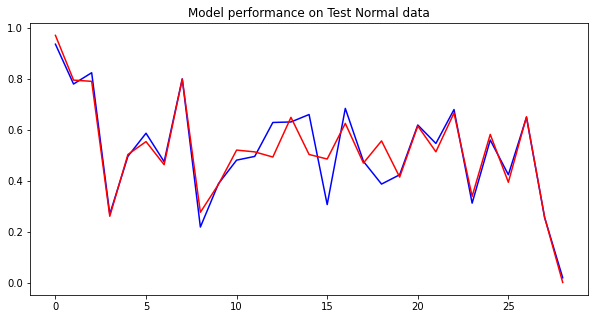

In [127]:
fig = plt.figure(figsize = (10, 5))
plt.plot(X_test[2], 'b')
plt.plot(decoder_out[2], 'r')
plt.title("Model performance on Test Normal data")
plt.show()

In [128]:
decoder_out = np.zeros( (data1.shape) , dtype=np.float64)

for fold in range(n_folds):
  #Test data
  scaler = fscalers[fold]
  X_test  = scaler.transform(data1)

  encoder_out = model.encoder(X_test).numpy() 
  decoder_out += model.decoder(encoder_out).numpy()

decoder_out /= n_folds

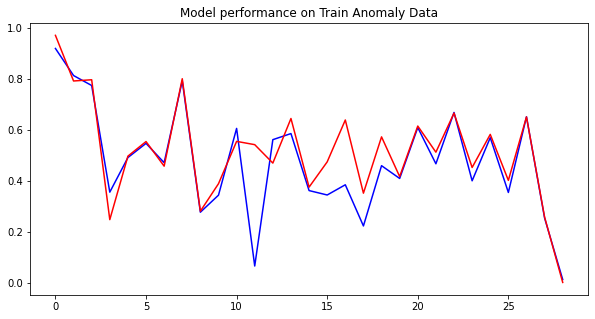

In [132]:
fig = plt.figure(figsize = (10, 5))
plt.plot(X_test[2], 'b')
plt.plot(decoder_out[2], 'r')
plt.title("Model performance on Train Anomaly Data")
plt.show()

Detecting anomalies
We will detect anomalies by determining how well our model can reconstruct the input data.

Find MAE loss on training samples.
Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

In [133]:
train_loss = 0

for fold in range(n_folds):
    trn_idx = folds[folds['fold'] != fold_num].index
    g_test  = data0.iloc[trn_idx].reset_index(drop=True).values.copy()

    scaler = fscalers[fold]
    X_train  = scaler.transform(g_test)

    model = models[fold]

    encoder_out = model.encoder(X_train).numpy() 
    decoder_out = model.decoder(encoder_out).numpy()
    train_loss += tf.keras.losses.mae(decoder_out, X_train).numpy()

train_loss /= n_folds

In [134]:
threshold = np.mean(train_loss) + np.std(train_loss)
print(threshold)

0.025503167136697015


In [135]:
preds = tf.math.less(train_loss, threshold)
pred_nc = tf.math.count_nonzero(preds).numpy()

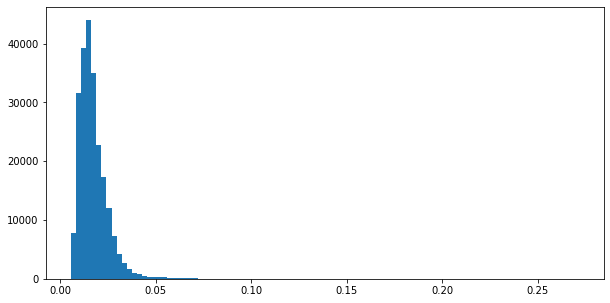

In [136]:
fig = plt.figure(figsize = (10, 5))
x = plt.hist(train_loss, bins=100)

In [137]:
loss_anomaly = 0

for fold in range(n_folds):
  # Anomaly data
  scaler = fscalers[fold]
  X_anomaly  = scaler.transform(data1)

  model = models[fold]

  encoder_out = model.encoder(X_anomaly).numpy() 
  decoder_out = model.decoder(encoder_out).numpy()
  loss_anomaly += tf.keras.losses.mae(decoder_out, X_anomaly).numpy()

loss_anomaly /= n_folds

In [138]:
preds_a = tf.math.greater(loss_anomaly, threshold)
pred_an = tf.math.count_nonzero(preds_a).numpy()

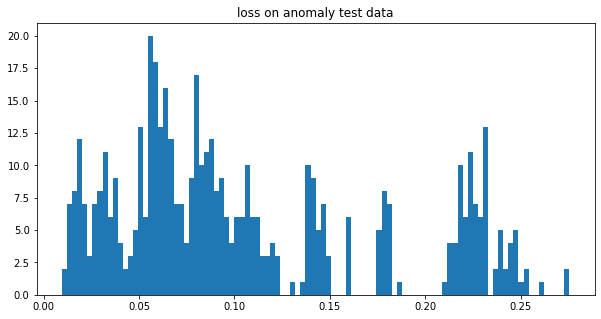

In [139]:
fig = plt.figure(figsize = (10, 5))
plt.hist(loss_anomaly, bins=100)
plt.title("loss on anomaly test data")
plt.show()

**Dataset evaluation**

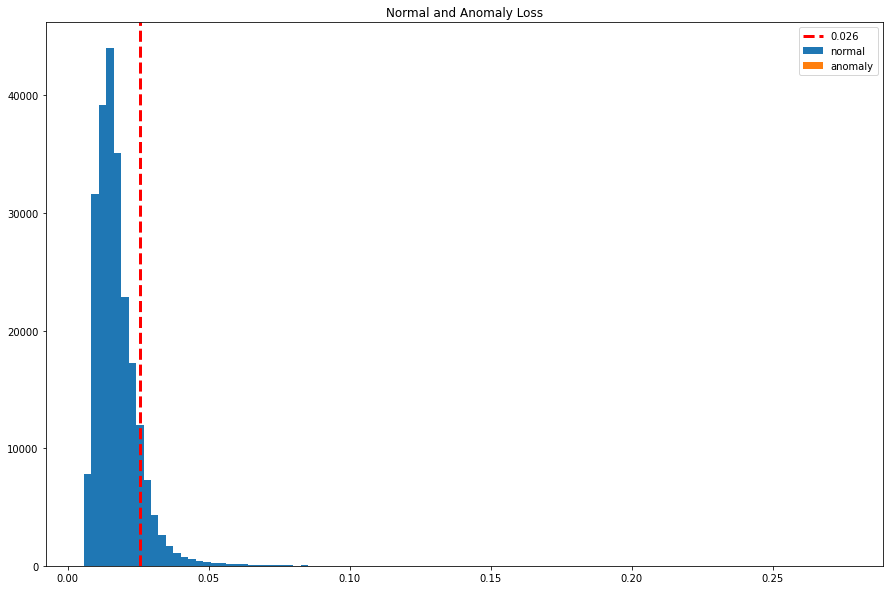

In [140]:
fig = plt.figure(figsize = (15, 10))
plt.hist(train_loss, bins=100, label='normal')
plt.hist(loss_anomaly, bins=100, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss")
plt.show()

In [141]:
threshold

0.025503167136697015

**Out of sample results**

In [142]:
holdout = pd.concat([holdout,data1],axis=0)
Class_holdout = pd.concat([Class_holdout,class1],axis=0)

In [148]:
preds_data  = np.zeros((holdout.shape[0]), dtype=np.int32)

for fold in range(n_folds):
   scaler = fscalers[fold]
   X_data  = scaler.transform(holdout)

   model = models[fold]

   reconstruction_data = model.predict(X_data)
   loss_data = tf.keras.losses.mae(reconstruction_data,X_data).numpy()
   preds_data += (loss_data >= threshold).astype(np.int32)

preds_data //= n_folds

In [149]:
# make predictions for test data and evaluate
accuracy = accuracy_score(Class_holdout, preds_data)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 83.61%


In [150]:
# confusion m,atrix
tn, fp, fn, tp = confusion_matrix(Class_holdout, preds_data).ravel()
print(tn, fp, fn, tp)

23740 4692 48 444


In [151]:
sensitivity = tp/(tp+fn)
print("Sensitivity: %.2f%%" % (sensitivity * 100.0))
specificity = tn/(tn+fp)
print("Specificity: %.2f%%" % (specificity * 100.0))

Sensitivity: 90.24%
Specificity: 83.50%


In [152]:
confusion_matrix(Class_holdout, preds_data)

array([[23740,  4692],
       [   48,   444]])